# SIIM-ACR Pneumothorax Segmentation
## Identifying Pneumothorax disease in chest x-rays using SageMaker
Amazon SageMaker is a fully managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK makes it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks, including PyTorch.

In this notebook, we use Amazon SageMaker to train a convolutional neural network using PyTorch and pneumothorax X-ray data, and then we host the model in Amazon SageMaker for inference.

# What is Pneumothorax
From Wikipedia:
"A pneumothorax is an abnormal collection of air in the pleural space between the lung and the chest wall. Symptoms typically include sudden onset of sharp, one-sided chest pain and shortness of breath. In a minority of cases, a one-way valve is formed by an area of damaged tissue, and the amount of air in the space between chest wall and lungs increases; this is called a tension pneumothorax. This can cause a steadily worsening oxygen shortage and low blood pressure and unless reversed can be fatal. Very rarely, both lungs may be affected by a pneumothorax. It is often called a "collapsed lung", although that term may also refer to atelectasis."

## How is the problem identified in an X-Ray?
The entities we can identify in a chest X-Ray could include:
* Air: Black spots
* Fluids & Tissues: Grey
* Bone & Solides: White

Air enclosures may possibly be just mild disturbances in the chest X-Ray. Convulutional Neural Networks are excellent at identifying abnormalities.

This exercise involves using chest X-rays and masks. The kernel used is based on UNet architecture with ResNet34 encoder. We have used segmentation_models.pytorch library which has many inbuilt segmentation architectures, details of which can be found [here](https://github.com/qubvel/segmentation_models.pytorch). 

What's down below?

    UNet with imagenet pretrained ResNet34 architecture
    Training on 512x512 sized images/masks with Standard Augmentations
    MixedLoss (weighted sum of Focal loss and dice loss)
    Gradient Accumulution

## Setup
We start by installing some required dependencies including the segmentation_models.pytorch and albumentations (used for transforming images during pre-processing)
Additionally, we will set-up:


* An Amazon S3 bucket and prefix for training and model data. This should be in the same region used for SageMaker Studio, training, and hosting.
* An IAM role for SageMaker to access to your training and model data. If you wish to use a different role than the one set up for SageMaker Studio, replace sagemaker.get_execution_role() with the appropriate IAM role or ARN. For more about using IAM roles with SageMaker, see the AWS documentation.


In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip3 install albumentations
!pip install pydicom # Digital medical imaging

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-o2_qbaku
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-o2_qbaku
Processing /root/.cache/pip/wheels/9c/03/81/494596f1d017bbf80daf53bc33dbb05aaa5a6ad6d44c74011f/pretrainedmodels-0.7.4-py3-none-any.whl
Processing /root/.cache/pip/wheels/1c/07/d1/ff77968842daae1dde944173a8e8a7be193646d37842f13b24/efficientnet_pytorch-0.6.3-py3-none-any.whl
  Using cached timm-0.1.20-py3-none-any.whl (161 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-py3-none-any.whl size=53464 sha256=267f0458ca8382633f69329697073b8697c44291b9b6beb46425d9b5dd189348
  Stored in directory: /tmp/pip-ephem-wheel-cache-pg3ivr4o/wheels/53/e5/fc/18292d80d3c0f4efc96cbbb72625fdbafdca303997bacfb085
Successfully built segmentation-models-pytorch
Processing /root/.cache/pip/wheels/78/d2/b4/

In [2]:
import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'sagemaker/pytorch-cnn-pneumothorax'

role = sagemaker.get_execution_role()

## Data Exploration
We will take a look at some sample images that are available. Since these are DICOM images, we expect to have some meta-data available in addition to the pixel data that comes as part of the image. 

In [3]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from matplotlib import cm
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")
import segmentation_models_pytorch as smp

import glob
import pydicom
from tqdm import tqdm_notebook

## Utility Functions for Data Exploration
The below functions will be used to reach DICOM files and plot them

In [4]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    #display_name = pat_name.family_name + ", " + pat_name.given_name
    #print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

Starting to plot images
Filename.........: ./input/train/1.2.276.0.7230010.3.1.4.8323329.5081.1517875186.321334.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient id..........: 6657ea5b-494c-4ae2-af9a-883c95270149
Patient's Age.......: 62
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 128324 bytes
Pixel spacing....: [0.171, 0.171]


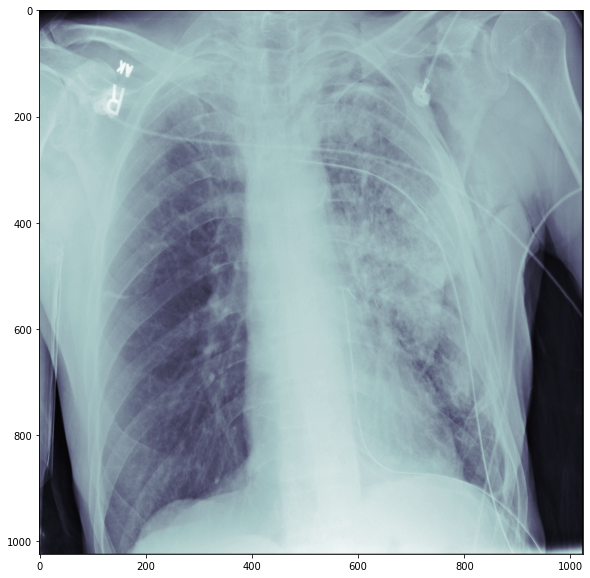

In [5]:
import sys
sys.path.insert(0, './input/train')

from mask_functions import rle2mask
print("Starting to plot images")
pathname='./input/train/*.dcm'

for file_path in glob.glob(pathname, recursive=True):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

We will also look at a collection of images and associated metadata

5
./input/sample/1.2.276.0.7230010.3.1.4.8323329.303.1517875162.295039.dcm
1.2.276.0.7230010.3.1.4.8323329.303.1517875162.295039
Filename.........: ./input/sample/1.2.276.0.7230010.3.1.4.8323329.303.1517875162.295039.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient id..........: 019a6d6a-4eac-4372-a1d4-fe9193826333
Patient's Age.......: 44
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130602 bytes
Pixel spacing....: [0.171, 0.171]
./input/sample/1.2.276.0.7230010.3.1.4.8323329.304.1517875162.301989.dcm
1.2.276.0.7230010.3.1.4.8323329.304.1517875162.301989
Filename.........: ./input/sample/1.2.276.0.7230010.3.1.4.8323329.304.1517875162.301989.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient id..........: fa43083b-0d94-4849-a5c4-40120c380164
Patient's Age.......: 60
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......

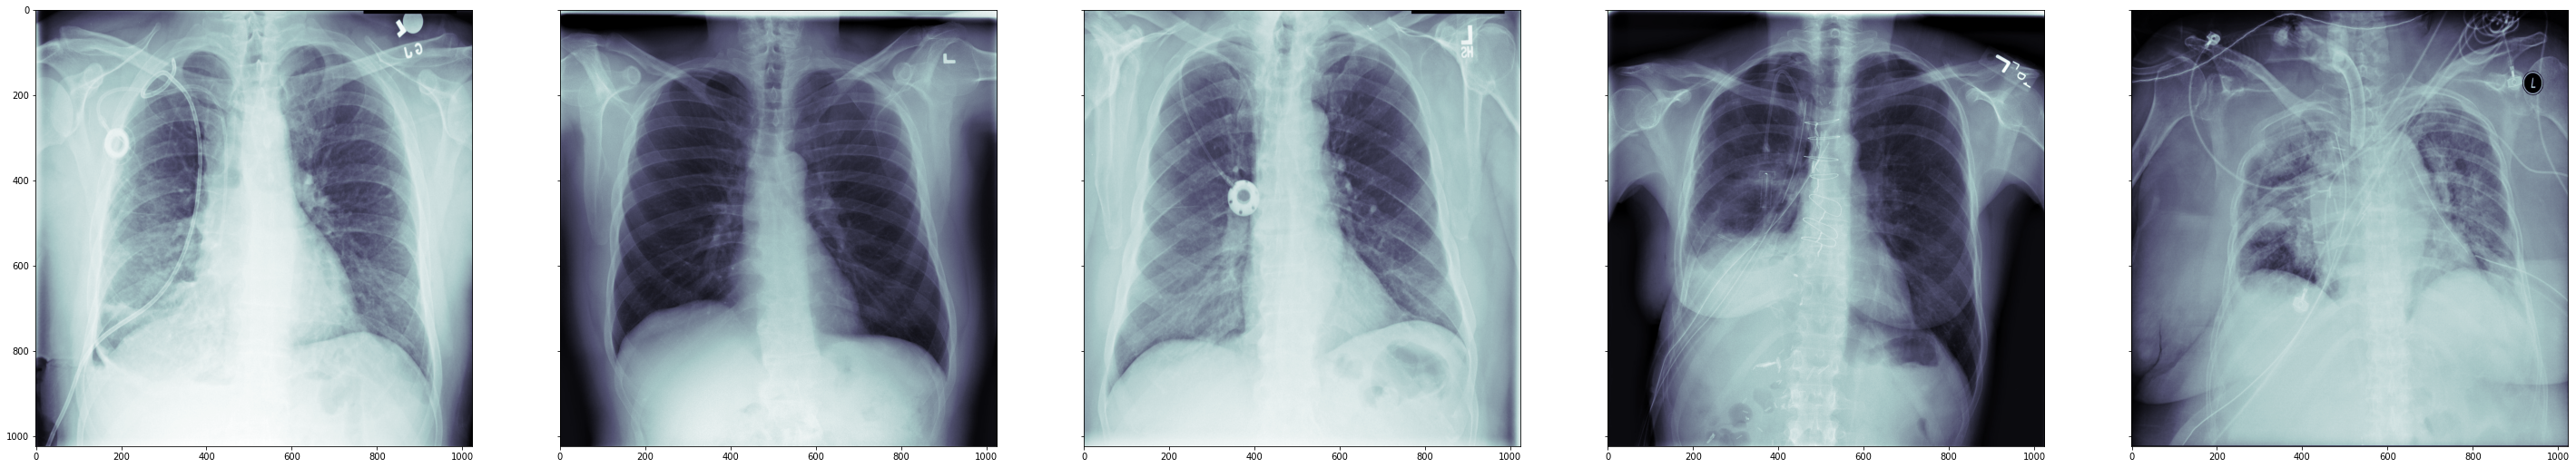

In [6]:
pathname='./input/sample/*.dcm'

num_img = len(glob.glob(pathname))
print(num_img)
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob(pathname)):
    locate = file_path.split('/')[-1][:-4]
    print(file_path)
    print(locate)
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)

We will then look at the images with the masks plotted on them:

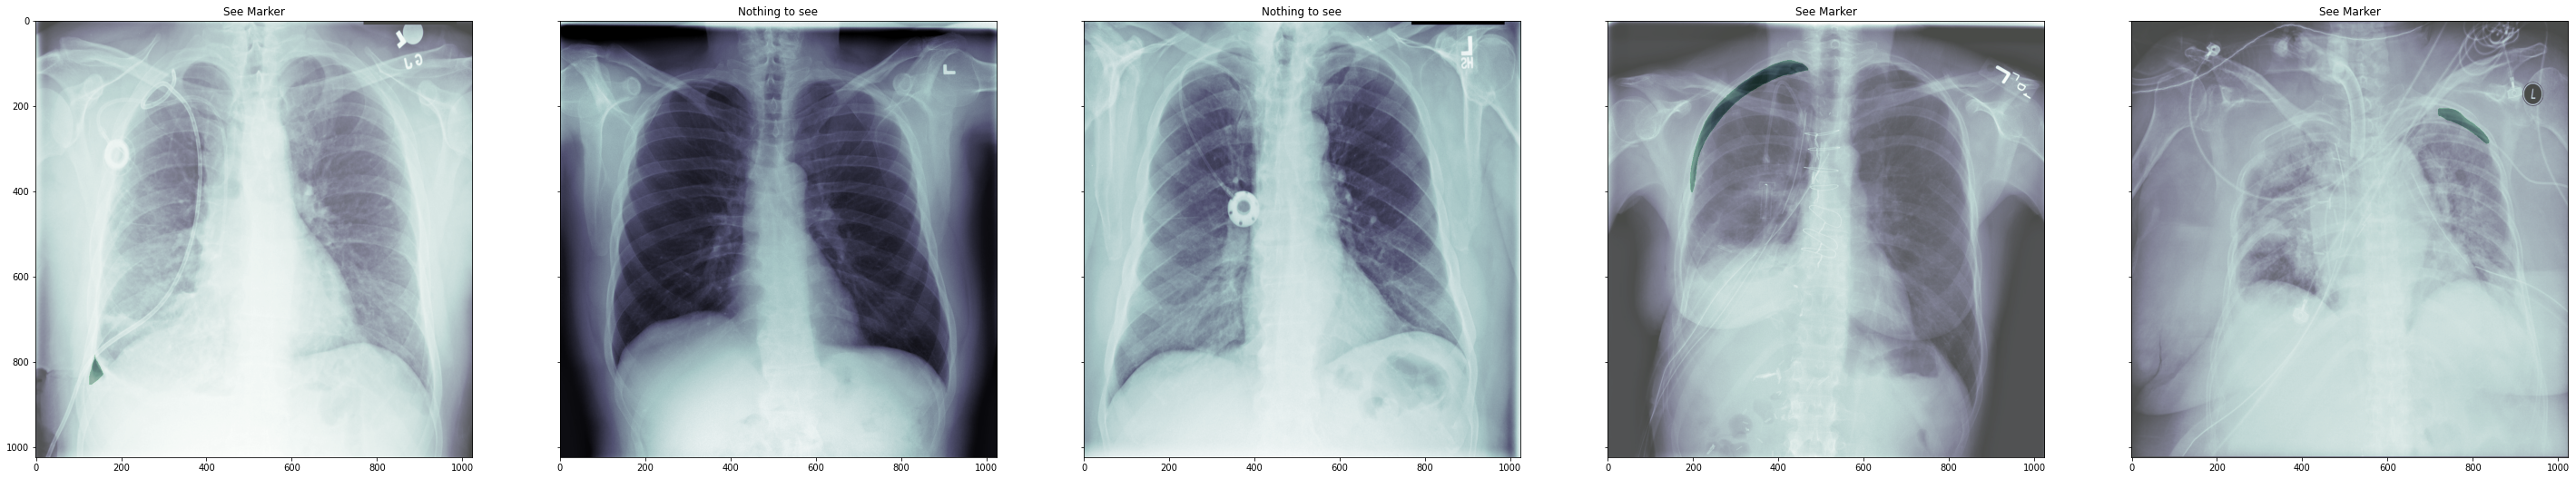

In [85]:
df = pd.read_csv('./input/train-rle.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('./input/sample/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Greens")
    else:
        ax[q].set_title('Nothing to see')

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, input_dir, image_data, size, mean, std, phase):
        self.input_dir = input_dir
        self.image_data = image_data

        self.transform = get_transforms(phase, size, mean, std)

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        
        encoded_pix = self.image_data.iloc[idx, 1]
        image_id = self.image_data.iloc[idx, 0]
        image_path = os.path.join(self.input_dir, image_id +".png")
        image = cv2.imread(image_path)

        mask = np.zeros([1024, 1024])
        
        if encoded_pix != '-1':
            mask += decode(encoded_pix)
            
        if self.transform:
            augmented = self.transform(image=image , mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        return [image, mask]

## Utility Functions for Loading and Transforming Images

In [8]:
def load_data(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    df_all = pd.read_csv(df_path)
    df = df_all.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != "-1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == "-1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask), random_state=69) # random state is imp
    df = pd.concat([df_with_mask, df_without_mask_sampled])
    
    #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    
    for train_index, val_index in kfold.split(df["ImageId"], df["has_mask"]):
        print("TRAIN:", train_index, "TEST:", val_index)
        train_df, val_df = df.iloc[train_index], df.iloc[val_index]

    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
        
    image_dataset = SimDataset(data_folder, df, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def decode(rle, height=1024, width=1024, fill_value=1):
    decoded = np.zeros((height, width), np.float32)
    decoded = decoded.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        decoded[start: end] = fill_value
        start = end
    decoded = decoded.reshape(width, height).T
    return decoded

def encode(data):
    data = data.T.flatten()
    start = np.where(data[1:] > data[:-1])[0]+1
    end = np.where(data[:-1] > data[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [9]:
train_data_folder = './input/train_png'
train_df_folder = './input/train-rle.csv'

In [10]:
mean = (0.485, 0.456, 0.406),
std = (0.229, 0.224, 0.225)

In [11]:
dataloader = load_data(
    fold=0,
    total_folds=5,
    data_folder=train_data_folder,
    df_path=train_df_folder,
    phase='train',
    size = 512,
    mean = mean,
    std = std,
    batch_size=8,
    num_workers=0,
)

TRAIN: [   0    1    2 ... 5334 5336 5337] TEST: [   5   14   15 ... 5324 5326 5335]
TRAIN: [   0    3    4 ... 5335 5336 5337] TEST: [   1    2    6 ... 5330 5331 5332]
TRAIN: [   1    2    4 ... 5335 5336 5337] TEST: [   0    3    7 ... 5307 5310 5334]
TRAIN: [   0    1    2 ... 5335 5336 5337] TEST: [   4   11   22 ... 5328 5329 5333]
TRAIN: [   0    1    2 ... 5333 5334 5335] TEST: [  12   13   18 ... 5325 5336 5337]


In [12]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch

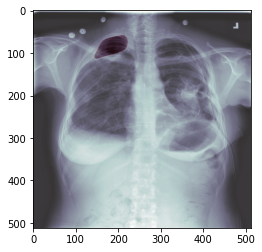

In [13]:
# plot some random images in the `batch`
idx = random.choice(range(8))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.2, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

## Loss Functions

In [14]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

## Utility Functions for Score Calculation

In [15]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    if phase == 'train':
        print("train-loss: %0.4f | train-dice: %0.4f | train-dice-neg: %0.4f | train-dice-pos: %0.4f | train-IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    else:
        print("validation-loss: %0.4f | validation-dice: %0.4f | validation-dice-neg: %0.4f | validation-dice-pos: %0.4f | validation-IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))        
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

## Create a UNet Model with ResNet34

In [16]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

## View Model Summary

In [17]:
!pip install torchsummary
!pip install ipywidgets

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

## Entry Point Script (Model Training & Validation)

SageMaker runs a Python script for model training and inference. The script serves as an entrypoint for a Docker container). For convinience, we will put the training and inference code in the same file. 

## Training
The script used for training is very similar to what one would use outside of the SageMaker environment. However, we are able to use a number of environment variables from the training environment to facilitate the training jobs. We have used the following environment variables available in a SageMaker Studio training environment:
* SM_HOSTS: a list of hosts on the container network.
* SM_CURRENT_HOST: the name of the current container on the container network.
* SM_MODEL_DIR: the location for model artifacts. This directory is uploaded to Amazon S3 at the end of the training job.
* SM_CHANNEL_TRAINING: the location of our training data.
* SM_NUM_GPUS: the number of GPUs available to the current container.

We also use a main guard (if __name__=='__main__':) to ensure that our training code is executed only for training, as SageMaker imports the entry-point script.

## Inference

For inference, we need to implement a few specific functions to tell SageMaker how to load our model and handle prediction input.

* model_fn(model_dir): loads the model from disk. This function must be implemented.
* input_fn(serialized_input_data, content_type): deserializes the prediction input.
* predict_fn(input_data, model): calls the model on the deserialized data.
* output_fn(prediction_output, accept): serializes the prediction output.

The last three functions - input_fn, predict_fn, and output_fn - are optional because SageMaker has default implementations to handle common content types. However, there is no default implementation of model_fn for PyTorch models on SageMaker, so our script has to implement model_fn.

Below is the full script for both training and hosting our convolutional neural network:

In [20]:
!pygmentize ./source/unet.py

import argparse
import json
import logging
import sagemaker_containers
import time

import os
import cv2
import pdb
import warnings
import random
import numpy as np
import pandas as pd

import torch
import torch.distributed as dist

from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler

import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp
from loss import *

from siim import *

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        ## tor

## Upload the data

We use the sagemaker.s3.S3Uploader to upload our dataset to Amazon S3. The return value inputs identifies the location -- we use this later for the training job.

In [23]:
from sagemaker.s3 import S3Uploader
inputs = S3Uploader.upload('input/train_png', 's3://{}/{}'.format(bucket, prefix))

In [21]:
inputs = 's3://'+bucket+'/'+prefix

## Run a SageMaker training job

The SageMaker Python SDK makes it easy for us to interact with SageMaker. Here, we use the PyTorch estimator class to start a training job. We configure it with the following parameters:

   * entry_point: our training script.
   * role: an IAM role that SageMaker uses to access training and model data.
   * framework_version: the PyTorch version we wish to use. For a list of supported versions, see here.
   * train_instance_count: the number of training instances.
   * train_instance_type: the training instance type. For a list of supported instance types

In [ ]:
from sagemaker.pytorch import PyTorch

siim_estimator = PyTorch(entry_point='unet.py',
                         source_dir = './source',
                            role=role,
                            framework_version='1.4.0',
                            train_instance_count=1,
                            train_instance_type='ml.p3.2xlarge',
                            hyperparameters = {'epochs': 20, 'batch_size': 4, 'lr': 5e-4},
                            metric_definitions=[
                                {'Name': 'train:loss', 'Regex': 'train-loss:(.*?)\|'},
                                {'Name': 'validation:loss', 'Regex': 'validation-loss:(.*?)\|'},
                                {'Name': 'train:dice-loss', 'Regex': 'train-dice:(.*?)\|'},
                                {'Name': 'validation:dice-loss', 'Regex': 'validation-dice:(.*?)\|'},
                                {'Name': 'train:dice-neg', 'Regex': 'train-dice-neg:(.*?)\|'},
                                {'Name': 'validation:dice-neg', 'Regex': 'validation-dice-neg:(.*?)\|'},
                                {'Name': 'train:dice-pos', 'Regex': 'train-dice-pos:(.*?)\|'},
                                {'Name': 'validation:dice-pos', 'Regex': 'validation-dice-pos:(.*?)\|'}
                            ],
                            enable_sagemaker_metrics=True,
                        )
siim_estimator.fit(inputs)

INFO:sagemaker:Creating training-job with name: pytorch-training-2020-06-19-20-32-26-910


2020-06-19 20:32:27 Starting - Starting the training job...
2020-06-19 20:32:33 Starting - Launching requested ML instances.........
2020-06-19 20:34:02 Starting - Preparing the instances for training......
2020-06-19 20:35:12 Downloading - Downloading input data...............
2020-06-19 20:37:48 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-19 20:38:07,451 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-19 20:38:07,473 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-19 20:38:10,506 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-19 20:38:10,898 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-06-19 20:38:10,899 sagemaker-containers INFO     Generating setup.cfg
2020-06-19 2

## Monitoring and visualizing metrics for your own training algorithm
If you are performing model training on Amazon SageMaker using either one of the built-in deep learning framework containers such as the TensorFlow or PyTorch containers, or running your own algorithm container, you can now easily specify the metrics you want Amazon SageMaker to monitor and publish to your Amazon CloudWatch metrics dashboard. In the previous step, we specified the metrics of interest as part of the **metrics_definition** property we defined for the estimator. We can now visualise those metrics as described below:

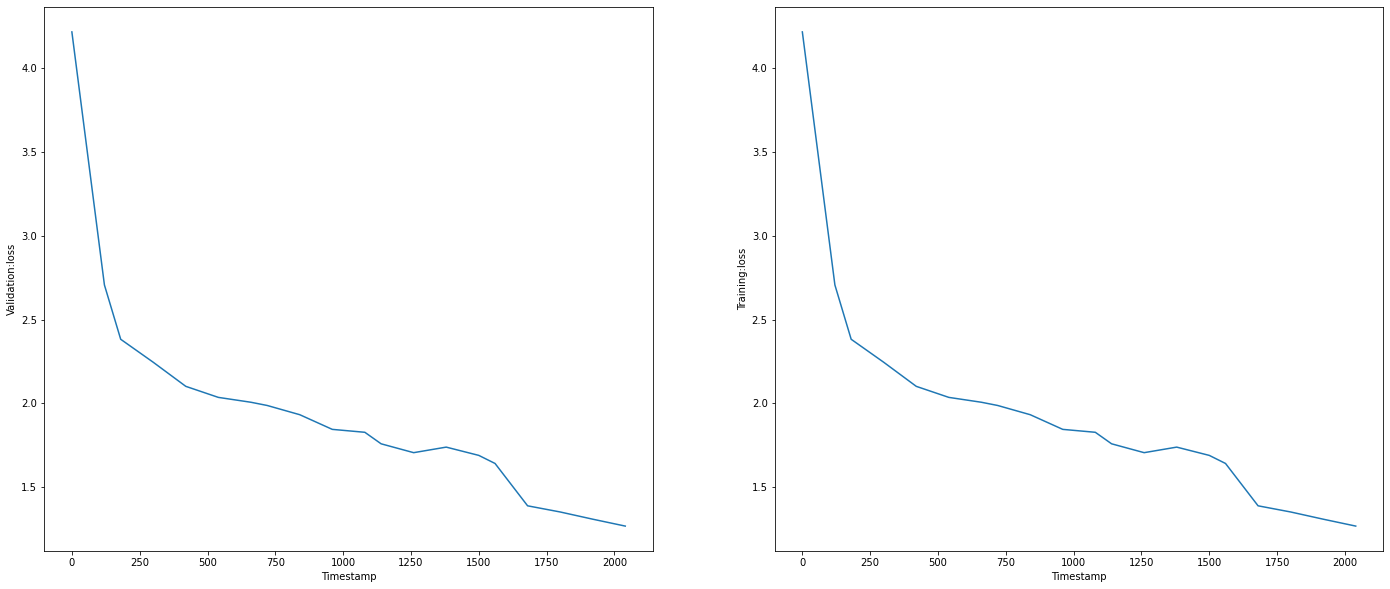

In [83]:
import matplotlib.pyplot as plt

training_job_name = 'pytorch-training-2020-06-19-20-32-26-910'

train_loss_df = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=['train:loss']).dataframe()
validation_loss_df = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=['train:loss']).dataframe()
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(validation_loss_df['timestamp'], validation_loss_df['value'])
ax2.plot(train_loss_df['timestamp'], train_loss_df['value'])

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Validation:loss')

ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Training:loss')
plt.figsize = (18,10)

plt.show()

## Setup Hyperparameter Training Jobs
While our first attempt at training yeilded promising results, we could experiment further with different hyperparameters to find the optimal set of parameters to train our model with. In this example we will work with the following hyperparameters:

* Learning Rate (lr)
* Batch-size
* Epochs

Please note that we are setting **early_stopping_type='Auto'** to enable automatic training job early stopping.

In [80]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

tuning_job_name = "pneumothorax-job-{}".format(datetime.now().strftime("%d-%H-%M-%S"))

hyperparameter_ranges = {'lr': ContinuousParameter(0.0004, 0.0005),
                         'batch_size': IntegerParameter(4, 6),
                         'epochs': IntegerParameter(30, 40)}

objective_metric_name = 'validation:loss'

metric_definitions=[
                                {'Name': 'train:loss', 'Regex': 'train-loss:(.*?)\|'},
                                {'Name': 'validation:loss', 'Regex': 'validation-loss:(.*?)\|'},
                                {'Name': 'train:dice-loss', 'Regex': 'train-dice:(.*?)\|'},
                                {'Name': 'validation:dice-loss', 'Regex': 'validation-dice:(.*?)\|'},
                                {'Name': 'train:dice-neg', 'Regex': 'train-dice-neg:(.*?)\|'},
                                {'Name': 'validation:dice-neg', 'Regex': 'validation-dice-neg:(.*?)\|'},
                                {'Name': 'train:dice-pos', 'Regex': 'train-dice-pos:(.*?)\|'},
                                {'Name': 'validation:dice-pos', 'Regex': 'validation-dice-pos:(.*?)\|'}
                            ]

tuner = HyperparameterTuner(siim_estimator, 
                            objective_metric_name, 
                            hyperparameter_ranges,
                            metric_definitions,
                            objective_type='Minimize', 
                            max_jobs=20, 
                            max_parallel_jobs=2,
                            early_stopping_type='Auto')

## Launch Hyperparameter Tuning Job
Now we can launch a hyperparameter tuning job by calling fit in tuner. Please note this can take a couple of hours to complete

In [ ]:
tuner.fit(inputs, 
          job_name=tuning_job_name, include_cls_metadata=False)
tuner.wait()

INFO:root:_TuningJob.start_new!!!
INFO:sagemaker:Creating hyperparameter tuning job with name: pneumothorax-job-19-22-29-38


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

After the tuning job finished, we again list the top 5 performing training jobs.

In [85]:
tuner_metrics_es = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics_es.dataframe().sort_values(['FinalObjectiveValue'], ascending=True).head(5)

batch_size  epochs        lr                            TrainingJobName  \
2         6.0    30.0  0.000441  pneumothorax-job-19-22-29-38-007-1f6f07b5   
0         6.0    30.0  0.000404  pneumothorax-job-19-22-29-38-009-223aa659   
1         6.0    30.0  0.000404  pneumothorax-job-19-22-29-38-008-93d77a03   
8         5.0    31.0  0.000432  pneumothorax-job-19-22-29-38-001-f5de0d54   
3         4.0    30.0  0.000489  pneumothorax-job-19-22-29-38-006-245be2f7   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
2         Completed               1.3867 2020-06-19 23:37:12+00:00   
0           Stopped               1.5707 2020-06-20 00:37:10+00:00   
1           Stopped               1.7016 2020-06-20 00:37:17+00:00   
8         Completed               1.7161 2020-06-19 22:32:18+00:00   
3         Completed               1.8253 2020-06-19 23:25:25+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
2 2020-06-20 00:33:46+00:00                      3394.0  
0 2020-06-20 00:55:07+00:00                      1077.0  
1 2020-06-20 00:55:08+00:00                      1071.0  
8 2020-06-19 23:34:49+00:00                      3751.0  
3 2020-06-20 00:25:10+00:00                      3585.0

The total training time and training jobs status can be checked with the following script.

In [86]:
df = tuner_metrics_es.dataframe()
total_time_es = df['TrainingElapsedTimeSeconds'].sum() / 3600
print("The total training time with early stopping is {:.2f} hours".format(total_time_es))
df['TrainingJobStatus'].value_counts()

The total training time with early stopping is 4.30 hours


Stopped      6
Completed    3
Name: TrainingJobStatus, dtype: int64

In [136]:
## Placeholder to deploy model from the first training run
#predictor = siim_estimator.deploy(initial_instance_count=1, framework_version='1.4.0', instance_type='ml.m4.xlarge')

## Deploy the model for inference

After training, we use the tuner object to build and deploy a PyTorchPredictor. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference, based on the best model in the tuner. Remember in previous steps, the tuner launched multiple training jobs during tuning and the resulting model with the best objective metric is defined as the best model.

As mentioned above we have implementation of model_fn in the unet.py script that is required. We are going to use default implementations of input_fn, predict_fn, output_fn and transform_fm defined in sagemaker-pytorch-containers.

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in mnist.py. Here we will deploy the model to a single ml.m5.xlarge instance.

In [147]:
predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

'pneumothorax-job-19-22-29-38-007-1f6f07b5'

In [152]:
##estimator = PyTorchModel(
##    model_data='s3://sagemaker-'+ region + '-' + account + '/'+ job_name +'/model.tar.gz', 
##    role=role, entry_point='source/unet.py', source_dir='source/', framework_version='1.4.0')

## Evaluate 
### Test Dataset Class

In [34]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
            fname = self.fnames[idx]
            path = os.path.join(self.root, fname + ".png")
            image = cv2.imread(path)
            images = self.transform(image=image)["image"]
            return [images, fname]
        
    def __len__(self):
        return self.num_samples

Specify the file path for mask and images

In [35]:
test_submission_path = 'input/test_rle.csv'
test_data_folder = 'input/test_png'

### Initiate the Test Loader Class

In [36]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 0
batch_size = 16
best_threshold = 0.5
min_size = 3500
device = torch.device("cpu")
df = pd.read_csv(test_submission_path)
test_loader = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

### Utility functions for plotting Images from Test Data

In [37]:
import torchvision
def show_img(img):
    """displays an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [38]:
def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

### Run Prediction against an Image in Test Data Set

In [64]:
it = iter(test_loader)
batch = next(it)
images, fnames = batch

In [65]:
index = 0
preds = predictor.predict(images[index].unsqueeze(0).to(device))
preds = torch.from_numpy(preds).float().to(device)
preds = torch.sigmoid(preds)
preds = preds.detach().cpu().numpy()[:, 0, :, :]

In [66]:
encoded_pixels = []
for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = encode(predict)
            encoded_pixels.append(r)

### Run Inference Against an Image

In [68]:
pixels = decode(encoded_pixels[0])  if encoded_pixels != -1 else 0

In [69]:
image = test_data_folder+'/'+fnames[index]+'.png'

In [70]:
image = cv2.imread(image)

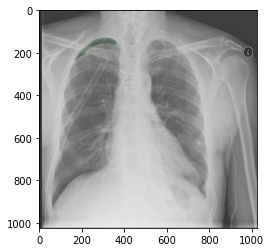

In [88]:
# plot some random images in the `batch`
plt.imshow(image, cmap='bone')
plt.imshow(pixels, alpha=0.2, cmap='Greens')
plt.show()
#if len(np.unique(masks[idx][0])) == 1: # only zeros
#    print('Chosen image has no ground truth mask, rerun the cell')